In [2]:
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

In [3]:
def time_decompose(raw_df,col_name='timestamp'):
    raw_df['datetime'] = pd.to_datetime(raw_df[col_name])
    raw_df['time'] = raw_df.datetime.apply(lambda x: x.timetuple())
    raw_df['timestamp'] = raw_df.time.apply(lambda x: int(time.mktime(x)))
    raw_df['hour'] = raw_df.time.apply(lambda x: x.tm_hour)
    raw_df['minute'] = raw_df.time.apply(lambda x: x.tm_min)
    raw_df.drop('time',axis=1,inplace=True)
    return raw_df

In [4]:
def anomal(real_value,high_border,low_border):
    result_label = []
    for i in range(len(real_value)):
        result_label.append( 1 if real_value[i]>high_border[i] or real_value[i]<low_border[i] else 0)
    return result_label

In [5]:
std = pd.read_csv("../data/hour_minute_3std.csv",sep=',')
predict_df = pd.read_csv("../data/predict_result_gbdt.csv",sep=',')
df = time_decompose(predict_df,'timestamp')
df.head()

,timestamp,value,label,predict_value,datetime,hour,minute
0,1500155220,2.016949,0,2.136026,2017-07-16 05:47:00,5,47
1,1500155280,1.966102,0,2.113482,2017-07-16 05:48:00,5,48
2,1500155340,1.949153,0,2.054298,2017-07-16 05:49:00,5,49
3,1500155400,2.050848,0,2.012150,2017-07-16 05:50:00,5,50
4,1500155460,2.016949,0,2.059163,2017-07-16 05:51:00,5,51


In [6]:
new_df = pd.merge(df,std,how='left',on=['hour','minute'])
new_df['high_border'] = new_df['predict_value'] + new_df['3std']
new_df['low_border'] = new_df['predict_value'] - new_df['3std']
new_df['predict_label'] = anomal(new_df.value, new_df.high_border, new_df.low_border)

In [7]:
# new_df[(new_df.label==1) ^ (new_df.predict_label==1)][['label','predict_label','datetime','value','high_border','low_border']].to_csv("../data/temp_pre_label.csv",index=False)

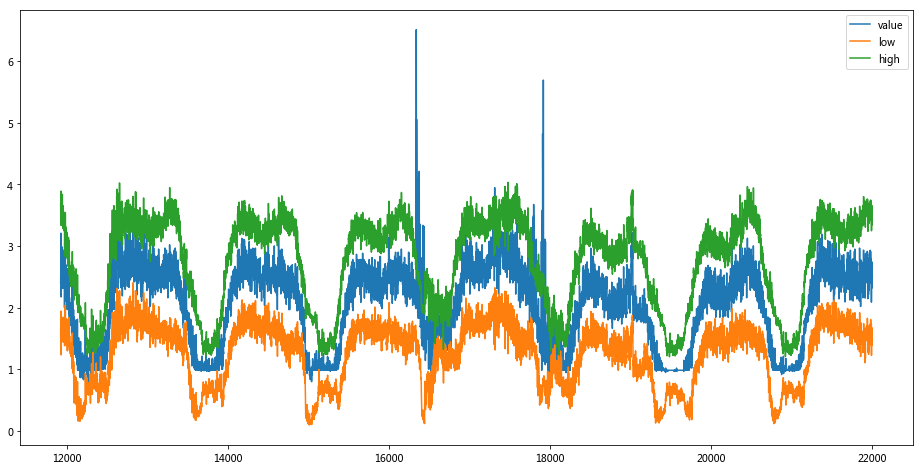

In [8]:
plt.figure(figsize=(16,8))
new_df['value'][-7*24*60:].plot( label = 'value')
new_df['low_border'][-7*24*60:].plot(label='low')
new_df['high_border'][-7*24*60:].plot(label = 'high')
plt.legend(loc='best')
plt.show()

In [9]:
def metric(real_label, predict_label):
    precision = metrics.precision_score(real_label,predict_label)
    recall = metrics.recall_score(real_label, predict_label)
    f1score = metrics.f1_score(real_label,predict_label)
    conf_matrix = metrics.confusion_matrix(new_df.label, new_df.predict_label)
    print("precision:%.4f \nrecall: %.4f \nf1_score:%.4f " %(precision, recall,f1score))
    print("\nconfusion matrix:\n", conf_matrix)
#     return conf_matrix
metric(new_df.label, new_df.predict_label)

precision:0.9200 
recall: 0.6614 
f1_score:0.7695 

confusion matrix:
 [[20734    69]
 [  406   793]]


In [10]:
temp_df = new_df[-7*24*60:]
normal_ts = temp_df[temp_df.label==0]['value']
abnormal_ts = temp_df[temp_df.label==1]['value']

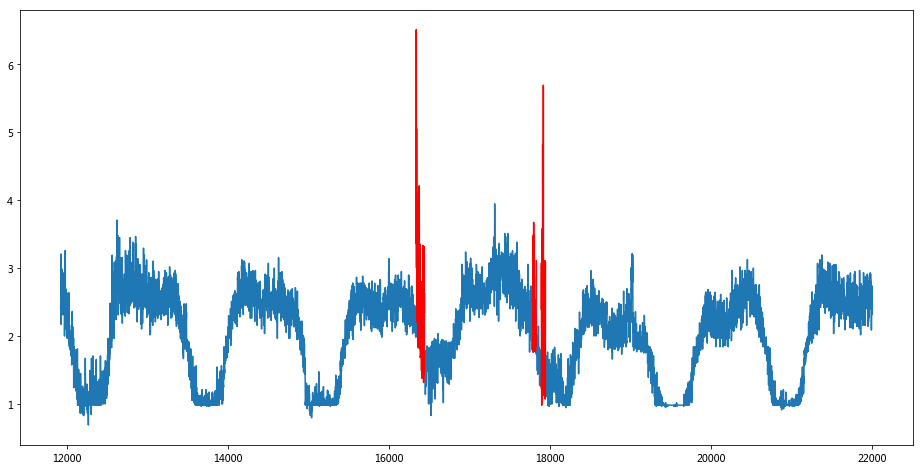

In [11]:
plt.figure(figsize=(16,8))
normal_ts.plot(label='normal')
abnormal_ts[:104].plot(color='r',label='abnormal')
abnormal_ts[105:-52].plot(color='r')
abnormal_ts[-52:].plot(color='r')
plt.show()